In [ ]:
import glob
import cv2
import imutils
from google.colab.patches import cv2_imshow
import numpy as np
import pandas as pd
from skimage import io

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
num_list=[]
for x in range(1,47):
  num_list.append(x)

images = []
for i in num_list:
    file_list = glob.glob('/content/drive/MyDrive/MMU-Iris-Database/' + str(i) + '/left/*.*')
    for file in file_list:
      im = cv2.imread(file)
      images.append(im)
    file_list = glob.glob('/content/drive/MyDrive/MMU-Iris-Database/' + str(i) + '/right/*.*')
    for file in file_list:
      im = cv2.imread(file)
      images.append(im)

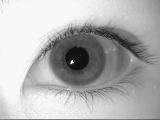

Image after gaussian blur and canny edge detection--


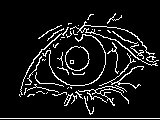

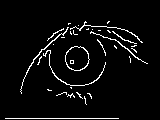

In [ ]:
img = images[1]
img = cv2.resize(img ,(160,120))
output = img.copy()
gray_image = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
cv2_imshow(gray_image)


image_test = cv2.GaussianBlur(gray_image, (7, 7), 1)
image_test = cv2.Canny(image_test, 20, 70, apertureSize=3)
print("Image after gaussian blur and canny edge detection--")
cv2_imshow(image_test)

hough_circle = cv2.HoughCircles(image_test, cv2.HOUGH_GRADIENT, 1.3, 800)
if hough_circle is not None:
    hough_circle = np.round(hough_circle[0, :]).astype("int")
    for (x, y, radius) in hough_circle:
        cv2.circle(output, (x, y), radius, (255, 0, 0), 4)
		
image_test = gray_image
image_test = cv2.GaussianBlur(image_test, (7, 7), 1)
image_test = cv2.Canny(image_test, 100, 120, apertureSize=3)
cv2_imshow(image_test)

circles = cv2.HoughCircles(image_test,cv2.HOUGH_GRADIENT,1,800,
                            param1=50,param2=20,minRadius=0,maxRadius=60)
circles = np.round(circles[0, :]).astype("int")
 
for (x, y, r) in circles:
		cv2.circle(output, (x, y), r, (0, 255, 0), 2)
		cv2.rectangle(output, (x - 2, y - 2), (x + 2, y + 2), (0, 128, 255), -1)

#cv2_imshow(output)

In [ ]:
inputimgs=[]
inputimgs1=[]
outputimgs=[]
outputimgs_iris=[]
for img in images:
  img = cv2.resize(img ,(160,120))
  output = img.copy()
  gray_image = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  #print("Image after grayscaling--")
  #cv2_imshow(gray_image)

  image_test = cv2.Canny(gray_image, 20, 70, apertureSize=3)
  image_test = cv2.GaussianBlur(gray_image, (7, 7), 1)
  #image_test = adjust_gamma(image_test,0.5)
  #print("Image after gaussian blur and canny edge detection--")
  #cv2_imshow(image_test)

  #---------------------------------------------------------------------------------------------
  # Apply Sobelx in high output datatype 'float32'
  # and then converting back to 8-bit to prevent overflow
  sobelx_64 = cv2.Sobel(image_test,cv2.CV_32F,1,0,ksize=3)
  absx_64 = np.absolute(sobelx_64)
  sobelx_8u1 = absx_64/absx_64.max()*255
  sobelx_8u = np.uint8(sobelx_8u1)

  # Similarly for Sobely
  sobely_64 = cv2.Sobel(image_test,cv2.CV_32F,0,1,ksize=3)
  absy_64 = np.absolute(sobely_64)
  sobely_8u1 = absy_64/absy_64.max()*255
  sobely_8u = np.uint8(sobely_8u1)

  # From gradients calculate the magnitude and changing
  # it to 8-bit (Optional)
  mag = np.hypot(sobelx_8u, sobely_8u)
  mag = mag/mag.max()*255
  mag = np.uint8(mag)

  # Find the direction and change it to degree
  theta = np.arctan2(sobely_64, sobelx_64)
  angle = np.rad2deg(theta)
  #print("Image after finding edges using Intensity gradient--")
  #cv2_imshow(mag)
  # Find the neighbouring pixels (b,c) in the rounded gradient direction
  # and then apply non-max suppression
  M, N = mag.shape
  Non_max = np.zeros((M,N), dtype= np.uint8)

  for i in range(1,M-1):
      for j in range(1,N-1):
        # Horizontal 0
          if (0 <= angle[i,j] < 22.5) or (157.5 <= angle[i,j] <= 180) or (-22.5 <= angle[i,j] < 0) or (-180 <= angle[i,j] < -157.5):
              b = mag[i, j+1]
              c = mag[i, j-1]
          # Diagonal 45
          elif (22.5 <= angle[i,j] < 67.5) or (-157.5 <= angle[i,j] < -112.5):
              b = mag[i+1, j+1]
              c = mag[i-1, j-1]
          # Vertical 90
          elif (67.5 <= angle[i,j] < 112.5) or (-112.5 <= angle[i,j] < -67.5):
              b = mag[i+1, j]
              c = mag[i-1, j]
          # Diagonal 135
          elif (112.5 <= angle[i,j] < 157.5) or (-67.5 <= angle[i,j] < -22.5):
              b = mag[i+1, j-1]
              c = mag[i-1, j+1]           
              
          # Non-max Suppression
          if (mag[i,j] >= b) and (mag[i,j] >= c):
              Non_max[i,j] = mag[i,j]
          else:
              Non_max[i,j] = 0

  #print("Image after applying Non-max suppression--")
  #cv2_imshow(Non_max)

  # Set high and low threshold
  highThreshold = 21
  lowThreshold = 15

  M, N = Non_max.shape
  out = np.zeros((M,N), dtype= np.uint8)

  # If edge intensity is greater than 'High' it is a sure-edge
  # below 'low' threshold, it is a sure non-edge
  strong_i, strong_j = np.where(Non_max >= highThreshold)
  zeros_i, zeros_j = np.where(Non_max < lowThreshold)

  # weak edges
  weak_i, weak_j = np.where((Non_max <= highThreshold) & (Non_max >= lowThreshold))

  # Set same intensity value for all edge pixels
  out[strong_i, strong_j] = 255
  out[zeros_i, zeros_j ] = 0
  out[weak_i, weak_j] = 75

  M, N = out.shape
  for i in range(1, M-1):
      for j in range(1, N-1):
          if (out[i,j] == 75):
              if 255 in [out[i+1, j-1],out[i+1, j],out[i+1, j+1],out[i, j-1],out[i, j+1],out[i-1, j-1],out[i-1, j],out[i-1, j+1]]:
                  out[i, j] = 255
              else:
                  out[i, j] = 0
  #print("Image after applying hysteresis thresholding--")
  #cv2_imshow(out)
  #---------------------------------------------------------------------------------------------
  circles = cv2.HoughCircles(out,cv2.HOUGH_GRADIENT,1,50,
                              param1=50,param2=50,minRadius=0,maxRadius=35)
  #print(len(circles))
  if(circles is not None):
    inputimgs.append(img)
    inputimgs1.append(gray_image)
    circles = np.round(circles[0, :]).astype("int")
    cx=0
    cy=0
    cr=0
    for (x, y, r) in circles:
        # draw the circle in the output image, then draw a rectangle
        # corresponding to the center of the circle
        cx = x
        cy = y
        cr = r
        cv2.circle(output, (x, y), r, (0, 255, 0), 2)
        #cv2.rectangle(output, (x - 5, y - 5), (x + 5, y + 5), (0, 128, 255), -1)

    #cv2.imshow('detected circles',output)
    # print(x,y,r)
    #print("Detecting iris----")
    #cv2_imshow(output)
    outputimgs.append(output)
    output1 = gray_image[cy-cr:cy+cr , cx-cr:cx+cr]
    #print("Segmenting iris part only----")
    outputimgs_iris.append(output1)
    #cv2_imshow(output1)
print(len(inputimgs))
print(len(outputimgs))

122
122


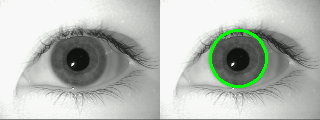

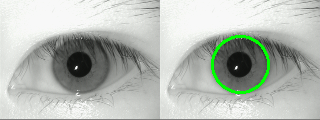

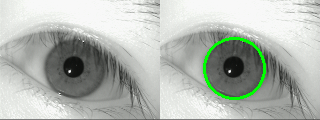

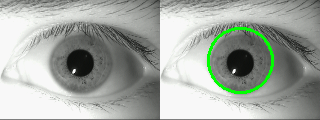

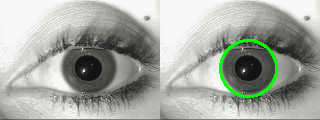

In [ ]:
indlist=[0,5,6,11,16]
for i in indlist:
  cv2_imshow(np.hstack([inputimgs[i],outputimgs[i]]))

24


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


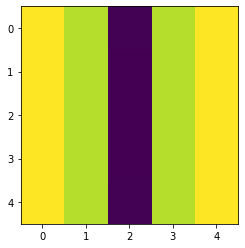

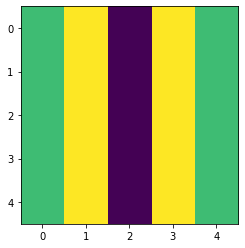

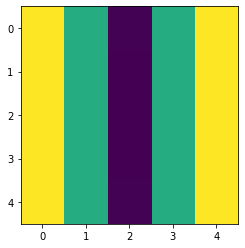

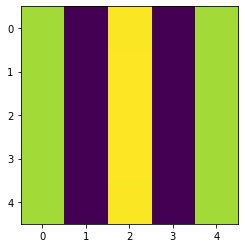

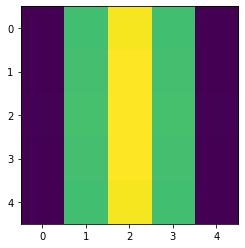

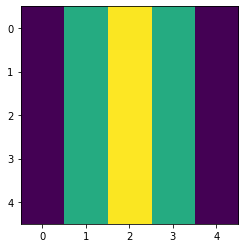

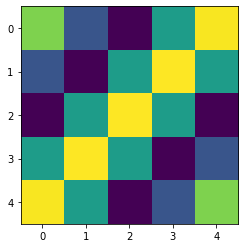

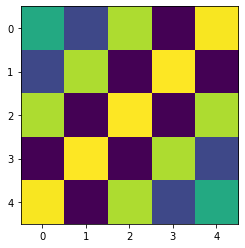

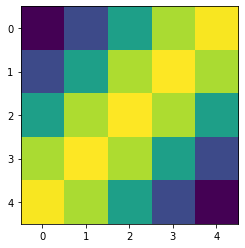

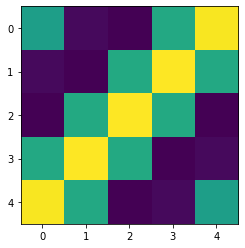

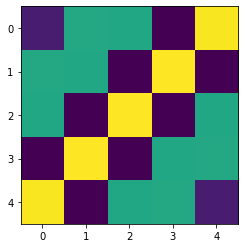

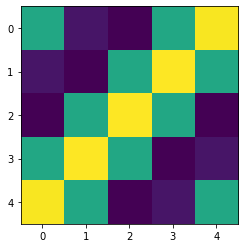

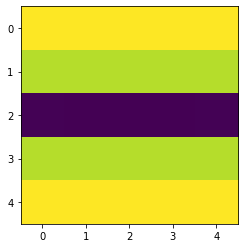

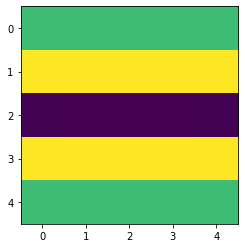

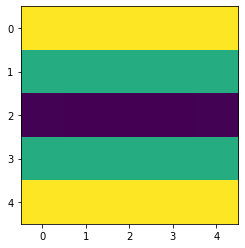

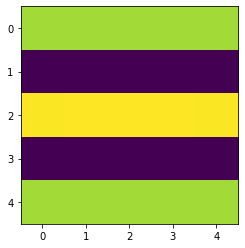

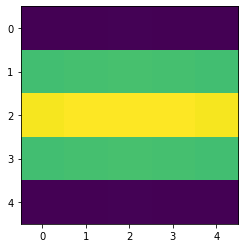

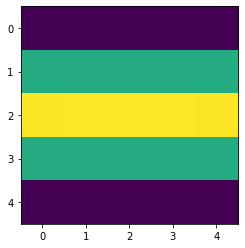

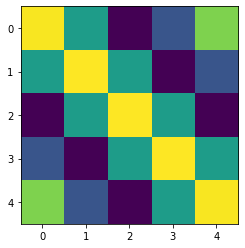

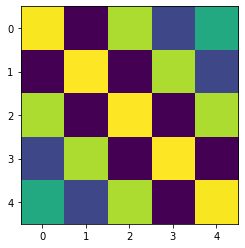

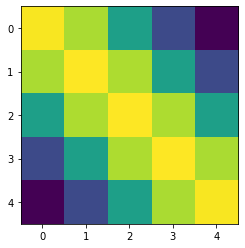

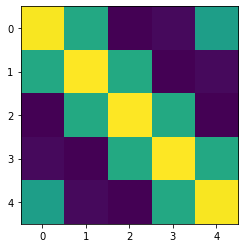

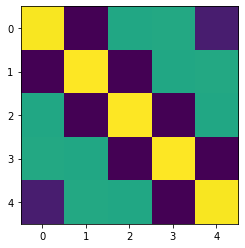

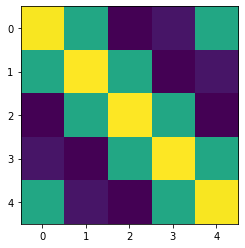

In [ ]:
from numpy.core.fromnumeric import shape
import matplotlib.pyplot as plt

def build_filters():
        filters = []
        ksize = 4
        sigma = 4
        thetas = [0, np.pi/4, np.pi /2 , 3* np.pi /4]
        llambda = [np.pi ,np.pi /2,np.pi /4,np.pi /8,np.pi /16,np.pi /32]
        for theta in thetas:
          for lamda in llambda:
            kern = cv2.getGaborKernel((ksize, ksize), sigma, theta, lamda, 0.25, 0, ktype=cv2.CV_32F)
            kern /= 1.5*kern.sum()
            filters.append(kern)
        return filters

def process(img, filters):
        accum = np.zeros_like(img)
        imgxx = img.copy()
        fvect = []
        for kern in filters:
            fimg = cv2.filter2D(img, cv2.CV_8UC3, kern)
            np.maximum(accum, fimg, accum)
            ffimg = cv2.filter2D(imgxx , cv2.CV_8UC3 , kern)
            #np.maximum(accum, ffimg, accum)
            xx=shape(ffimg)[0]
            yy=shape(ffimg)[1]
            #ffvect=[]
            for x in range(xx):
              for y in range(yy):
                fvect.append(ffimg[x][y])
            #fvect.append(ffvect)
        return accum,fvect

filters=build_filters()
print(len(filters))
for i in range(len(filters)):
  plt.figure()
  plt.imshow(filters[i])

460800
vlen: 460800 w: 4 wlen: 28800
(28800, 4, 4)
after taking mean: 28800
(20, 1440)
[157.125  156.25   155.375  ... 129.4375 135.8125 141.9375]
[148.0625 146.9375 145.6875 ... 112.625  116.5    120.0625]
Gabor Filtering--


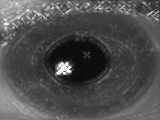

In [ ]:
res1,res11=process(gray_image,filters)
output1=outputimgs_iris[1]
output1=cv2.resize(output1,(160,120))
res2,vect=process(output1,filters)
print(shape(vect)[0])

ftlen = shape(vect)[0]
w=4
wlen =(int) (ftlen/(w*w))
print("vlen:",ftlen,"w:",w,"wlen:",wlen)
vectwin = []
ind = 0
for l in range(wlen):
  twin = np.zeros((4,4),dtype=int)
  for lx in range(4):
    for ly in range(4):
      twin[lx][ly]=vect[l]
      l=l+1
  vectwin.append(twin)
#print(shape(vectwin))
vectwin=np.array(vectwin)
print(shape(vectwin))
vv = []
for l in range(wlen):
  avg = np.mean(vectwin[l])
  vv.append(avg)
print("after taking mean:",shape(vv)[0])
vv=np.array(vv)
vv.resize(20,1440)
print(shape(vv))
print(vv[0])
print(vv[1])
print("Gabor Filtering--")
# cv2_imshow(res1)
cv2_imshow(res2)

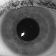

122
(56, 56)
(20, 1440)
[154.0625 153.5    152.8125 ... 123.75   128.125  132.375 ]
(20, 1440)
[157.125  156.25   155.375  ... 129.4375 135.8125 141.9375]
(20, 1440)
[156.25   154.875  153.3125 ... 108.4375 113.25   118.125 ]
(20, 1440)
[156.4375 155.875  155.1875 ... 116.6875 121.375  126.0625]
(20, 1440)
[151.5    151.125  150.75   ... 120.     118.3125 116.6875]
(20, 1440)
[114.8125 113.9375 113.     ...  77.1875  78.      78.375 ]
(20, 1440)
[ 98.1875  98.4375  98.75   ... 109.1875 107.75   106.25  ]
(20, 1440)
[100.5625  99.25    97.8125 ...  83.0625  84.3125  85.5625]
(20, 1440)
[118.5625 118.3125 118.0625 ...  88.1875  84.375   80.3125]
(20, 1440)
[54.25   53.875  53.5625 ... 63.1875 59.5    55.9375]
(20, 1440)
[141.75   141.75   141.8125 ... 133.1875 134.8125 136.375 ]
(20, 1440)
[109.6875 107.3125 105.9375 ...  81.3125  83.6875  86.25  ]
(20, 1440)
[124.0625 123.5    122.8125 ... 106.9375 110.4375 113.875 ]
(20, 1440)
[99.5625 98.0625 96.4375 ... 50.5    50.9375 51.25  ]
(20, 

In [ ]:
cv2_imshow(outputimgs_iris[0])
print(len(outputimgs_iris))
print(shape(outputimgs_iris[0]))

feature_vectors = []
for irisimg in outputimgs_iris:
  imgo = irisimg
  imgo=cv2.resize(imgo,(160,120))
  res2,vecti=process(imgo,filters)

  ftlen = shape(vecti)[0]
  w=4
  wlen =(int) (ftlen/(w*w))
  vectwin = []
  ind = 0
  for l in range(wlen):
    twin = np.zeros((4,4),dtype=int)
    for lx in range(4):
      for ly in range(4):
        twin[lx][ly]=vecti[l]
        l=l+1
    vectwin.append(twin)
  vectwin=np.array(vectwin)
  vv = []
  for l in range(wlen):
    avg = np.mean(vectwin[l])
    vv.append(avg)
  vv=np.array(vv)
  vv.resize(20,1440)
  print(shape(vv))
  print(vv[0])
  feature_vectors.append(vv)
print(shape(feature_vectors))